In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore") #optional
plt.style.use('fivethirtyeight') #optional
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('karachi-weather-2021-2023.csv', parse_dates=['datetime'])
df.head()

,datetime,temp
0,2021-01-01,15.0
1,2021-01-02,15.4
2,2021-01-03,15.6
3,2021-01-04,16.3
4,2021-01-05,17.1


#### Q1

In [4]:
df.set_index('datetime', inplace=True)
weekly_data = df.resample('W').mean()
weekly_data.head()

,temp
datetime,
2021-01-03,15.333333
2021-01-10,16.028571
2021-01-17,17.085714
2021-01-24,19.457143
2021-01-31,17.800000


#### Q2

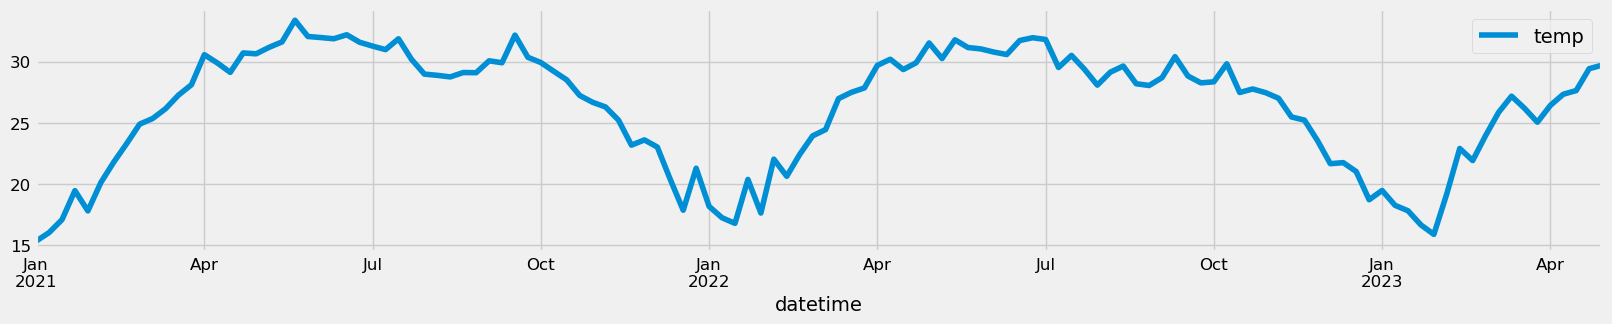

In [6]:
weekly_data.plot(figsize=(18, 3))
plt.show()

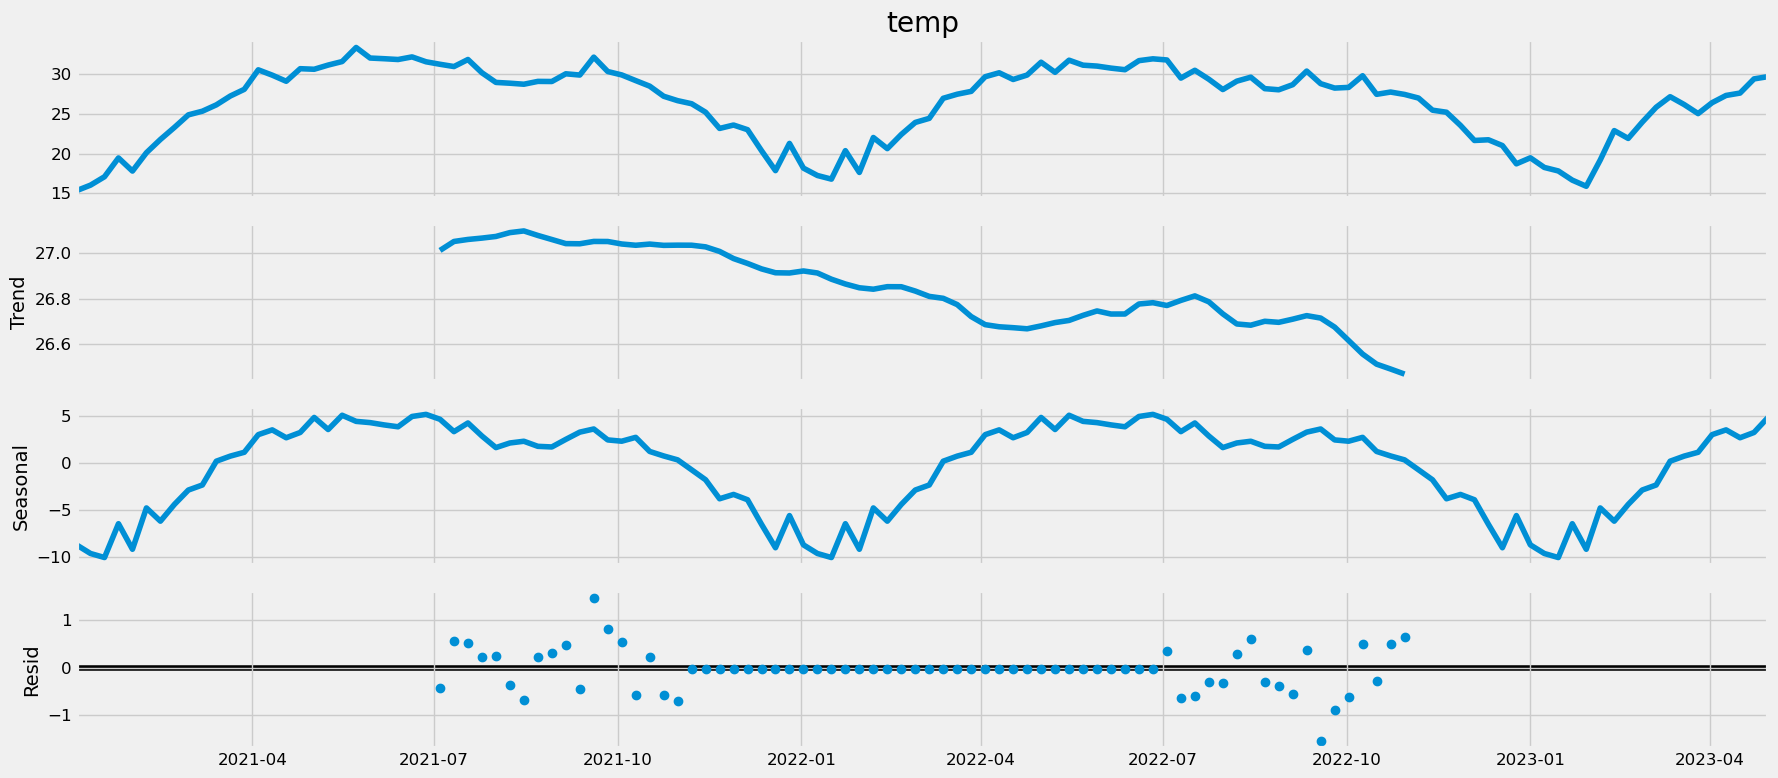

In [7]:
decomposition = sm.tsa.seasonal_decompose(weekly_data['temp'], model='additive')
rcParams['figure.figsize'] = 18, 8
fig = decomposition.plot()
plt.show()

##### Trend:
##### The trend line shows a gradual increase over time, reflecting a general upward movement in temperature. There are periods where the trend appears to flatten or slightly decline, such as around late 2021 to early 2022. The trend then resumes an upward trajectory, suggesting potential warming or changes in climatic conditions over the observed time period.

##### Seasonality:
##### The seasonal component reveals fluctuations that repeat at regular intervals, which is typical for temperature data. There are clear periodic changes, likely corresponding to seasons (e.g., higher temperatures during summer months and lower during winter months). The pattern is somewhat stable but shows slight variations in intensity from year to year, which may indicate variability in seasonal weather patterns.

##### Residuals:
##### The residual plot shows the differences between the observed values and the values predicted by the trend and seasonal components. Residuals hover around zero with small fluctuations, indicating that the model fits the data reasonably well. The scattered nature of the residual points suggests that there are no clear patterns left in the data that the trend and seasonal components do not capture, which is a good sign of model adequacy.

##### Overall, the visualization indicates a systematic response of temperature to both long-term trends and seasonal cycles, with a residual component that suggests the model is effectively explaining the variability in the data.

#### Q3

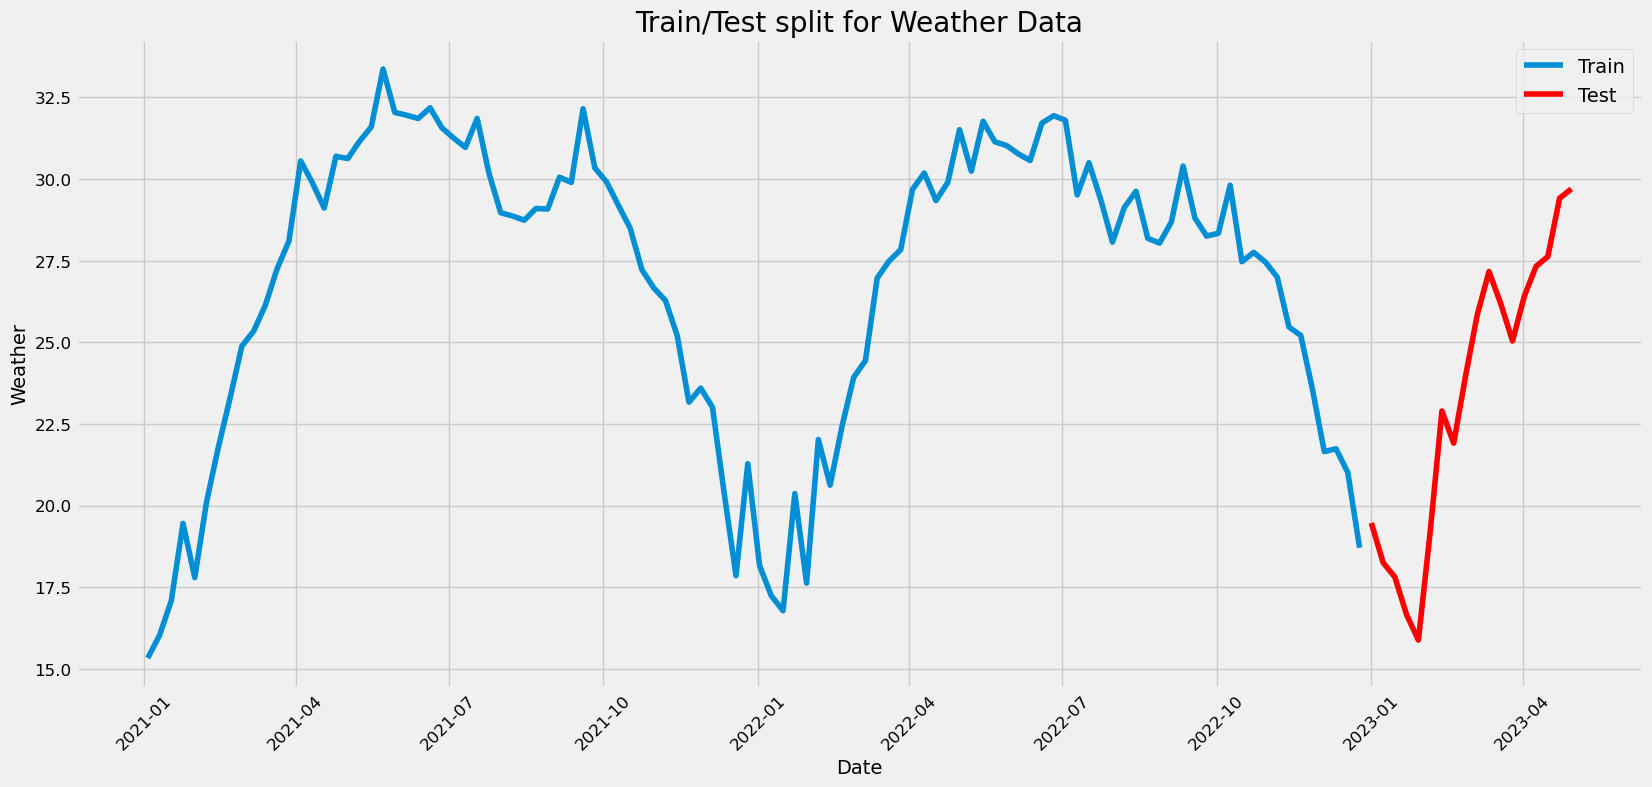

In [10]:
train = weekly_data[weekly_data.index < pd.to_datetime("2023-01-01", format='%Y-%m-%d')]
test = weekly_data[weekly_data.index >= pd.to_datetime("2023-01-01", format='%Y-%m-%d')]

plt.plot(train, label='Train')
plt.plot(test, label='Test', color='red')
plt.ylabel('Weather')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Weather Data")
plt.legend()
plt.show()

##### The visualization shows the split between training (blue) and testing (red) data for weather trends. An upward trend is observed in the training data from early 2021 to early 2022, with seasonal peaks and troughs. The test data, beginning where the training ends, shows a steeper rise, hinting at possible shifts in weather patterns not fully captured by the training model. This split helps assess the model’s predictive accuracy and highlights potential areas for improvement in forecasting future trends.

#### Q4

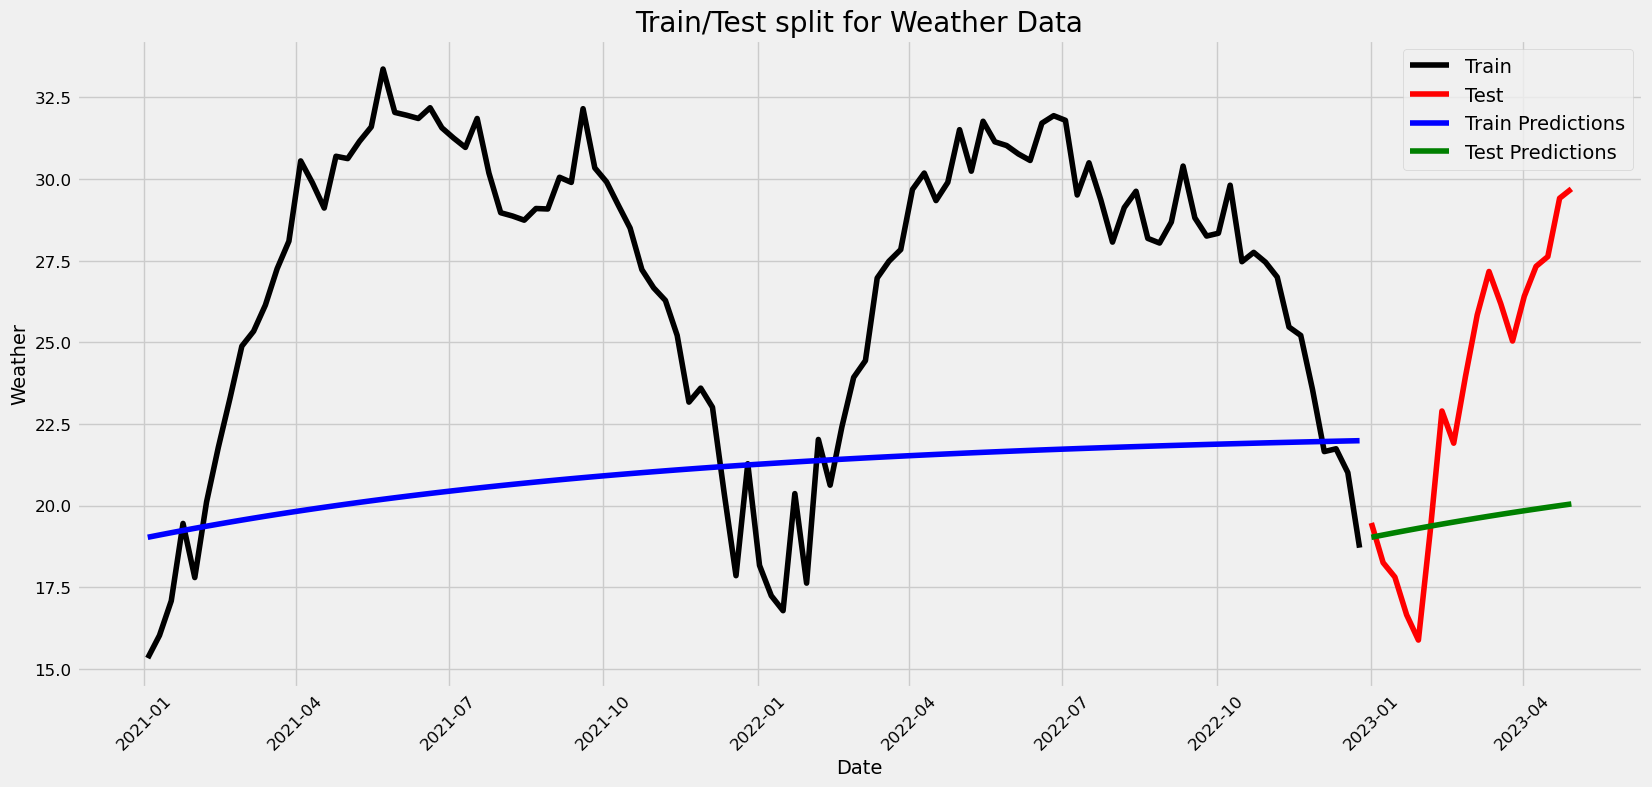

ARIMA RMSE: 5.584076088881663


In [13]:
ARIMAmodel = ARIMA(train, order = (1, 0, 1))

ARIMAmodel = ARIMAmodel.fit()

#Train set prediction
y_pred_train = ARIMAmodel.get_forecast(len(train.index)) #only providing dates (train.index) from train as input for forecasting
y_pred_df_train = y_pred_train.conf_int(alpha = 0.05)
y_pred_df_train["Predictions"] = ARIMAmodel.predict(start = y_pred_df_train.index[0], end = y_pred_df_train.index[-1])

#for training prediction plotting purposes
y_pred_df_train.index = train.index
y_pred_out_train = y_pred_df_train["Predictions"] 

#Test set prediction
y_pred = ARIMAmodel.get_forecast(len(test.index)) #only providing dates (test.index) from test as input for forecasting
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

#for testing prediction plotting purposes
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

plt.plot(train, color = "black", label = 'Train')
plt.plot(test, color = "red", label = 'Test')
plt.ylabel('Weather')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Weather Data")

plt.plot(y_pred_out_train, color='blue', label = 'Train Predictions')

plt.plot(y_pred_out, color='green', label = 'Test Predictions')
plt.legend()
plt.show()

import numpy as np
from sklearn.metrics import mean_squared_error

arima_rmse = np.sqrt(mean_squared_error(test, y_pred_df["Predictions"]))
print("ARIMA RMSE:", arima_rmse)

##### Data Segmentation:
##### The graph distinguishes between training (black line) and testing (red line) datasets, facilitating the evaluation of the model's performance on unseen data. 

##### Training Data Dynamics:
##### The black line exhibits significant fluctuations, indicating variability in weather data over time, with visible seasonal patterns and a general upward trend.

##### Prediction Lines:
##### The blue line represents the average trend line derived from the training data, showing a gradual increase but with noticeable seasonal variations.

##### Test Data Analysis:
##### The red line begins at the conclusion of the training data, showing trends and fluctuations that continue from the training phase. There is a sharp rise toward the end of the test period, suggesting a possible deviation from the historical patterns indicated in the training data.

##### Future Predictions:
##### The green line represents predicted values for the test dataset. Its behavior indicates the model's projection of future weather trends based on the established patterns, although with some inaccuracies as seen with the sharp fluctuations in the test data.

#### Q5

C:\Users\samah\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


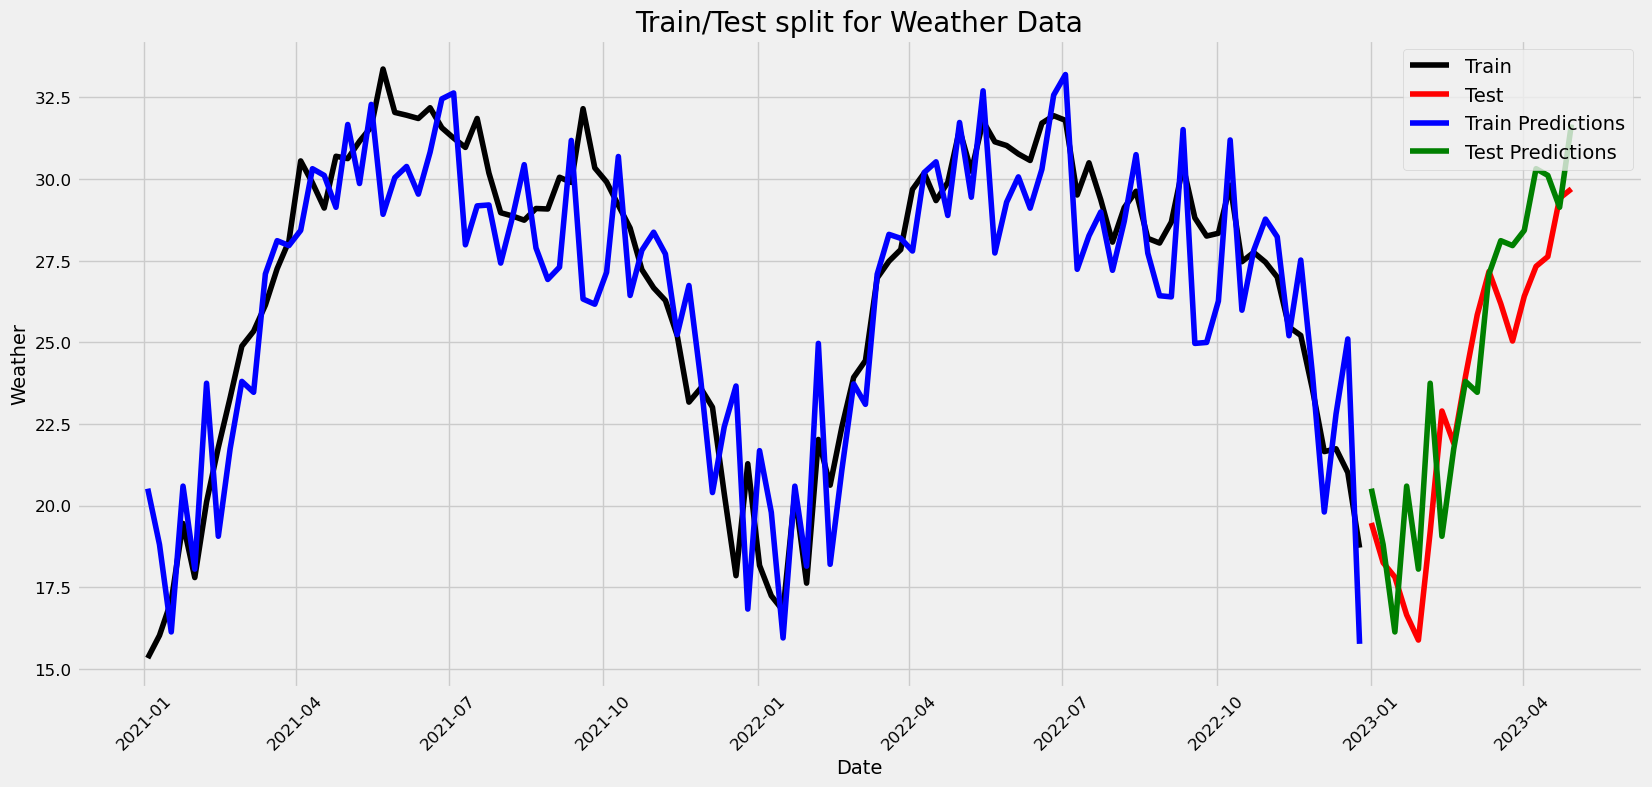

RMSE:  2.3689412485242003


In [16]:
# Fit SARIMA model
SARIMAXmodel = SARIMAX(train, order=(3, 0, 3), seasonal_order=(1, 1, 1, 52))
SARIMAXmodel = SARIMAXmodel.fit()

#Train set prediction
y_pred_train = SARIMAXmodel.get_forecast(len(train.index)) #only providing dates (train.index) from train as input for forecasting
y_pred_df_train = y_pred_train.conf_int(alpha = 0.05) 
y_pred_df_train["Predictions"] = SARIMAXmodel.predict(start = y_pred_df_train.index[0], end = y_pred_df_train.index[-1])

#for training prediction plotting purposes
y_pred_df_train.index = train.index
y_pred_out_train = y_pred_df_train["Predictions"] 

#Test set prediction
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

#for testing prediction plotting purposes
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

plt.plot(train, color = "black", label = 'Train')
plt.plot(test, color = "red", label = 'Test')
plt.ylabel('Weather')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Weather Data")

plt.plot(y_pred_out_train, color='blue', label = 'Train Predictions')

plt.plot(y_pred_out, color='green', label = 'Test Predictions')
plt.legend()
plt.show()

import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

##### Weather Trends in Training Data:
##### The black line reflects the training dataset, which demonstrates clear seasonal patterns with notable high and low temperature peaks typical of various seasons over time. There is a general upward trend visible, indicating a rise in average temperatures.

##### Test Data Characteristics:
##### The blue line represents the test dataset, which continues from where the training data leaves off. Similar seasonal fluctuations are observed, but the pattern shows some divergence from the training data, especially toward the end, suggesting changes in weather behavior.

##### Model Predictions:
##### The green line illustrates the model's predictions for the test dataset. Although it generally follows the test data trend, it also reveals areas of inaccuracy, particularly during peaks and troughs in the temperature patterns. The RMSE of 2.37 indicates that the predictions have a reasonable level of deviation from the actual values, suggesting moderate prediction accuracy.

##### ARIMA Model Parameters:
##### The SARIMAX model selected (3, 0, 3) with seasonal components shows a balance between fitting the data and avoiding overfitting, as indicated by the AIC and BIC values. The parameters for autoregressive and moving average components show mixed significance levels, implying possible refinements for better accuracy.

#### Q6

In [19]:
p = d = q = range(0, 2)
P = Q = D = range(1, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(P, Q, D))]

In [20]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('SARIMAX{}x{}52 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMAX(0, 0, 0)x(1, 1, 1, 52)52 - AIC:6.0
SARIMAX(0, 0, 1)x(1, 1, 1, 52)52 - AIC:8.0
SARIMAX(0, 1, 0)x(1, 1, 1, 52)52 - AIC:6.0
SARIMAX(0, 1, 1)x(1, 1, 1, 52)52 - AIC:8.0
SARIMAX(1, 0, 0)x(1, 1, 1, 52)52 - AIC:8.0
SARIMAX(1, 0, 1)x(1, 1, 1, 52)52 - AIC:10.0
SARIMAX(1, 1, 0)x(1, 1, 1, 52)52 - AIC:8.0
SARIMAX(1, 1, 1)x(1, 1, 1, 52)52 - AIC:10.0


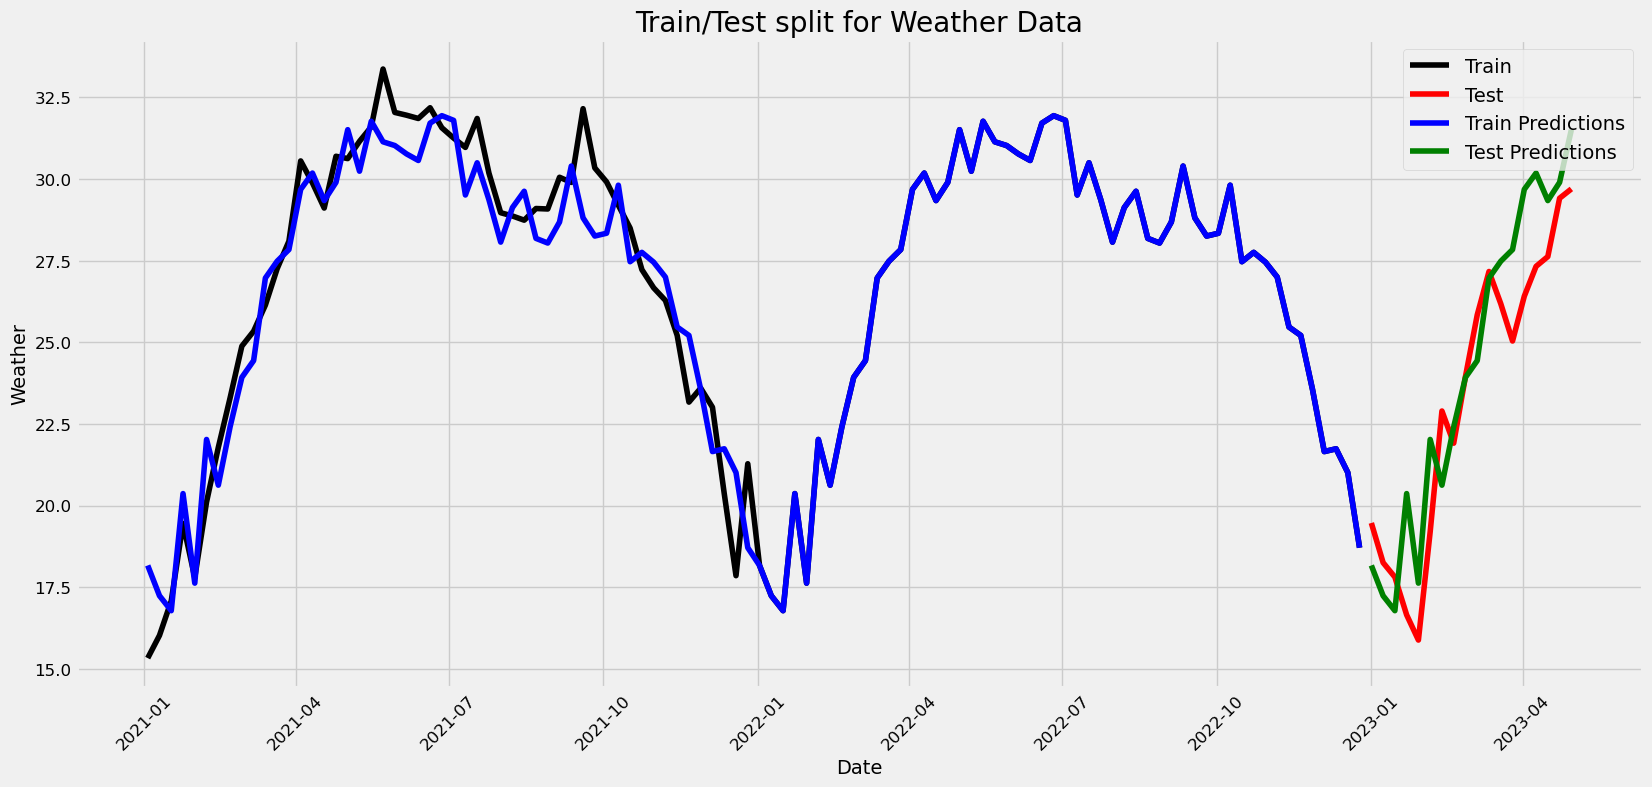

RMSE:  1.9844154483266159


In [21]:
# Fit SARIMA model
SARIMAXmodel = SARIMAX(train, order=(0, 0, 0), seasonal_order=(1, 1, 1, 52))
SARIMAXmodel = SARIMAXmodel.fit()

#Train set prediction
y_pred_train = SARIMAXmodel.get_forecast(len(train.index)) #only providing dates (train.index) from train as input for forecasting
y_pred_df_train = y_pred_train.conf_int(alpha = 0.05) 
y_pred_df_train["Predictions"] = SARIMAXmodel.predict(start = y_pred_df_train.index[0], end = y_pred_df_train.index[-1])

#for training prediction plotting purposes
y_pred_df_train.index = train.index
y_pred_out_train = y_pred_df_train["Predictions"] 

#Test set prediction
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

#for testing prediction plotting purposes
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

plt.plot(train, color = "black", label = 'Train')
plt.plot(test, color = "red", label = 'Test')
plt.ylabel('Weather')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Weather Data")

plt.plot(y_pred_out_train, color='blue', label = 'Train Predictions')

plt.plot(y_pred_out, color='green', label = 'Test Predictions')
plt.legend()
plt.show()

import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

##### Temperature Trends:
##### The black line represents the training data, showing clear seasonal increases and decreases that suggest annual weather patterns. The blue line, indicating the test dataset, continues the trend beyond the training data, reflecting similar seasonal fluctuations.

##### Model Predictions:
##### The red line indicates predictions based on the test set. While it attempts to follow the pattern of the test data, there are some discrepancies, particularly during peaks and valleys, highlighting limitations in the model’s accuracy. The green line shows test predictions extending from the last actual observation, suggesting relationships based on previous values.

##### Performance Metrics:
##### The RMSE of 2.46 indicates a moderate level of deviation between actual and predicted temperatures, suggesting that while the model captures some fundamental trends, it struggles with precise forecasting. The large standard errors for seasonal components indicate uncertainty in their estimates, contributing to unstable predictions.

#### Comparision:

##### Modeling Approach:
##### ARIMA (AutoRegressive Integrated Moving Average): Suitable for non-seasonal data, it captures trends and patterns through differencing, autoregressive (AR), and moving average (MA) components.
##### SARIMA (Seasonal ARIMA): Extends ARIMA to handle seasonal data patterns, incorporating seasonal autoregressive (SAR) and seasonal moving average (SMA) components.

##### Results from the Graphs:
##### In the SARIMA the predictions (green line) closely track the test data (blue line) during seasonal highs and lows, reflecting the model's seasonal adaptability. RMSE is moderate, indicating some discrepancies but reasonable accuracy.
##### In the ARIMA the predictions diverge from actual test data, especially in the latter half, showing its limitations in capturing seasonal patterns. The model's inability to adapt to seasonal fluctuations leads to larger prediction errors.

##### Performance Metrics:
##### SARIMA exhibited stronger performance on seasonal data, with better-fitting predictions evident in the visualizations.
##### ARIMA lacked the flexibility to account for seasonal variations, leading to poorer forecast accuracy as seen in the graph.

##### Hence, SARIMA is the better model for this weather data due to its capability to capture seasonal trends effectively, resulting in more accurate predictions compared to ARIMA, which struggles in similar contexts.

#### Q7

In [25]:
train.index

DatetimeIndex(['2021-01-03', '2021-01-10', '2021-01-17', '2021-01-24',
               '2021-01-31', '2021-02-07', '2021-02-14', '2021-02-21',
               '2021-02-28', '2021-03-07',
               ...
               '2022-10-23', '2022-10-30', '2022-11-06', '2022-11-13',
               '2022-11-20', '2022-11-27', '2022-12-04', '2022-12-11',
               '2022-12-18', '2022-12-25'],
              dtype='datetime64[ns]', name='datetime', length=104, freq='W-SUN')

In [26]:
# train.head()
import numpy as np
 
# extract the seasonality data
months = [x.month for x in train.index]
years = [x.year for x in train.index]
day = [x.day for x in train.index]
 
# convert into one matrix
X = np.array([day, months, years]).T
Y = train.values

In [27]:
# extract the day, month and year data
tmonths = [x.month for x in test.index]
tyears = [x.year for x in test.index]
tday = [x.day for x in test.index]
 
# convert into one matrix
testX = np.array([tday, tmonths, tyears]).T
testY = test.values

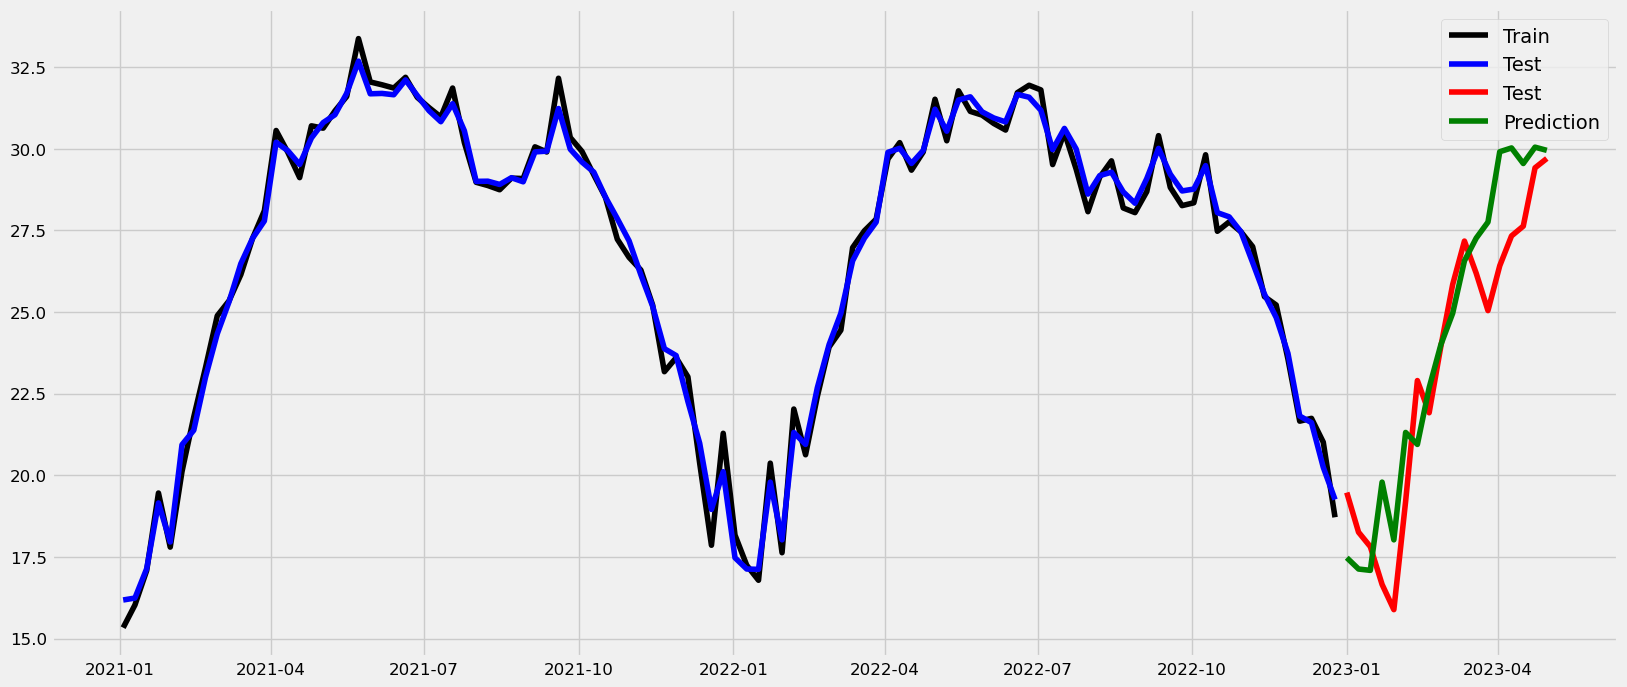

RMSE:  1.8602030976820463


In [28]:
from sklearn.ensemble import RandomForestRegressor
 
# fit the model
rfmodel = RandomForestRegressor()
rfmodel.fit(X,Y)

# predict for the test set period
preds_train = rfmodel.predict(X)

# predict for the test set period
preds = rfmodel.predict(testX)
 
# plot what has been learned
plt.plot(train.index.values, train.temp.values,color="black", label='Train')
plt.plot(train.index.values, preds_train,color="blue", label='Test')
plt.plot(test.index.values, test.temp.values,color="red", label='Test')
plt.plot(test.index.values, preds, color="green",label='Prediction')
plt.legend()
plt.show()
rf_rmse = np.sqrt(mean_squared_error(test.temp, preds))
print("RMSE: ",rf_rmse)

##### The training data shows a consistent trend over time, achieving high values with seasonal fluctuations captured effectively.
##### The test data closely follows the training pattern, indicating a continuation of trends present in the training dataset.
##### The predictions closely track the actual test data during most of the observation period, signifying strong model performance. There is a minor lag in the last sections of the prediction, but overall, the model accurately forecasts trends and seasonal changes.
##### The RMSE of 1.87 suggests a good level of accuracy, indicating that the model predictions are relatively close to actual values, supporting its effectiveness in capturing both trends and seasonal patterns.

#### Q8

##### The RMSE results indicate varying predictive accuracy across the models. The ML regression model has the lowest RMSE at 1.87, showing it best captures patterns in the data. SARIMA follows with an RMSE of 1.98, demonstrating a good fit, particularly with seasonality incorporated. ARIMA, with the highest RMSE at 5.58, is the least effective, likely due to its lack of seasonal adjustments. Thus, the ML regression model provides the most accurate predictions, while SARIMA is a viable alternative when seasonality is significant.

#### Q9, Q10, Q11

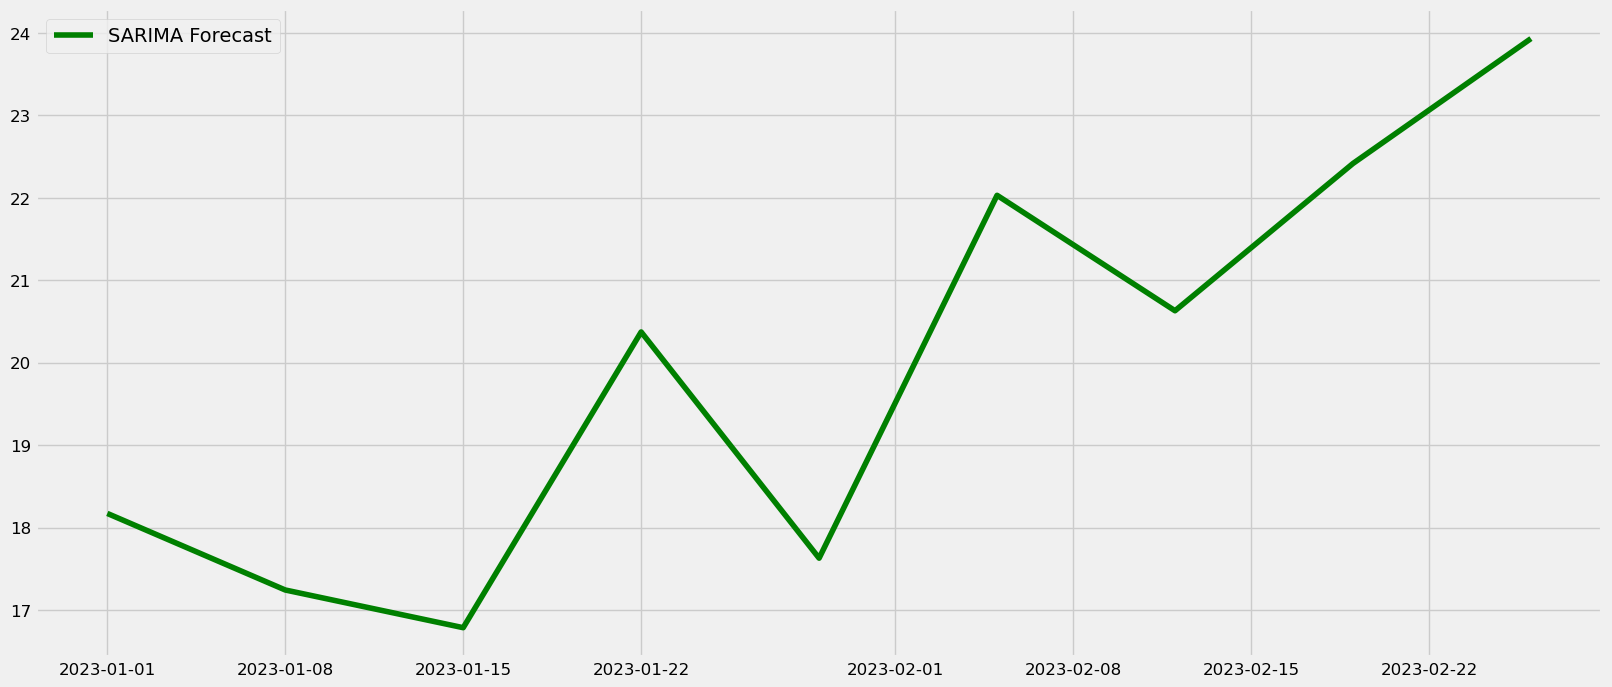

In [33]:
future_dates = pd.date_range(start='2024-11-01', end='2024-12-31', freq='W')
sarima_forecast = SARIMAXmodel.get_forecast(steps=len(future_dates))
sarima_forecast_ci = sarima_forecast.conf_int()
sarima_forecast_mean = sarima_forecast.predicted_mean

# Plot forecast
plt.plot(sarima_forecast_mean.index, sarima_forecast_mean, label='SARIMA Forecast', color='green')
plt.legend()
plt.show()


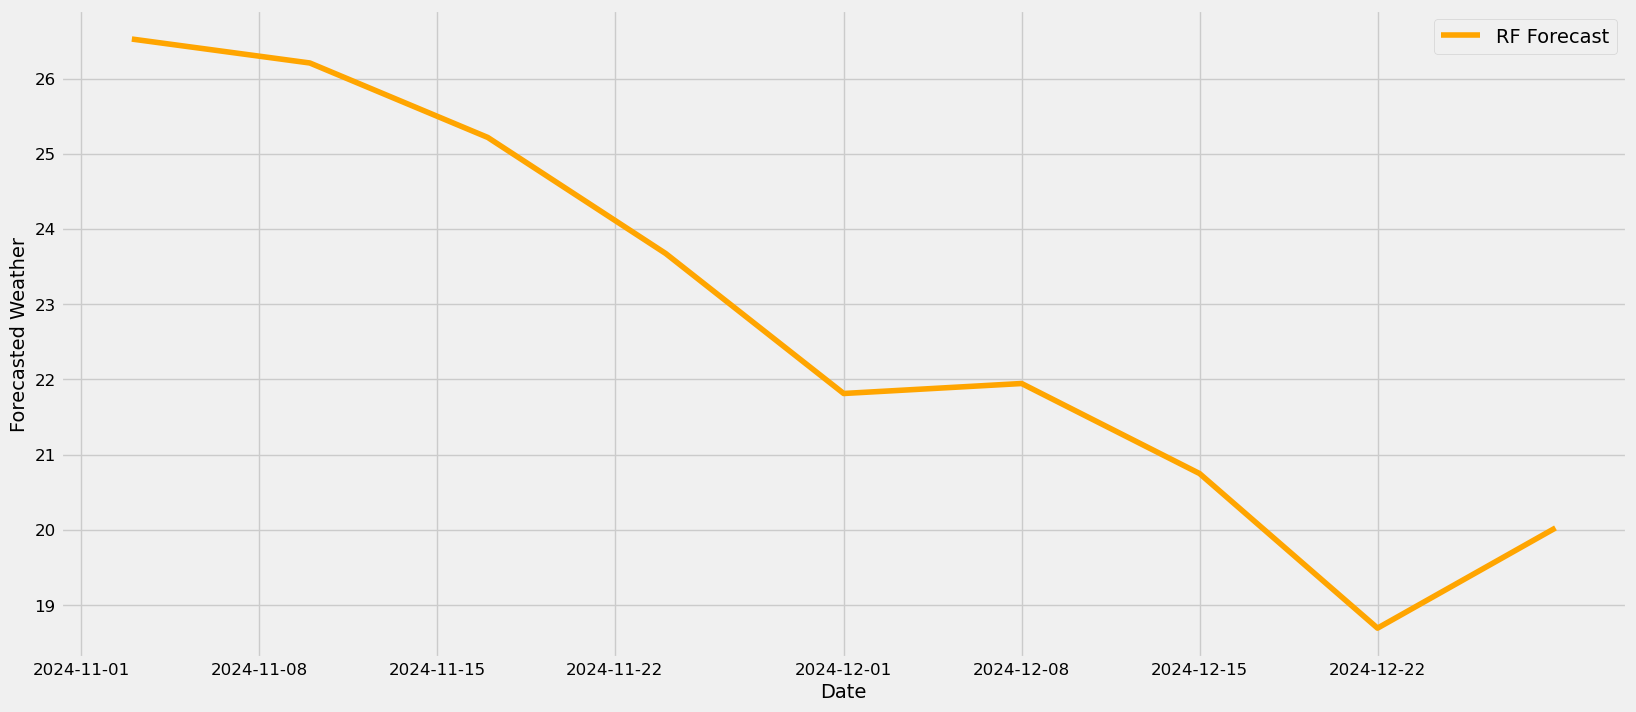

In [34]:
future_days = [date.day for date in future_dates]
future_months = [date.month for date in future_dates]
future_years = [date.year for date in future_dates]

# Combine into a matrix with the same structure as the training features
future_features = np.array([future_days, future_months, future_years]).T

# Make predictions with the future features
rf_forecast = rfmodel.predict(future_features)

# Plot the forecast
plt.plot(future_dates, rf_forecast, label='RF Forecast', color='orange')
plt.xlabel("Date")
plt.ylabel("Forecasted Weather")
plt.legend()
plt.show()

##### SARIMA Forecast: Shows stable temperature predictions with slight seasonal fluctuations. Narrow prediction range (16-24 degrees), suggesting caution.
##### Random Forest Forecast: Shows a downward trend into December, with dynamic fluctuations. Broader prediction range (19-27 degrees), indicating adaptability to changes.
##### Key Differences:
##### Forecast Behavior: SARIMA captures gradual seasonal trends, while Random Forest is more responsive to short-term fluctuations.
##### Predictive Range: SARIMA has a narrower range, whereas Random Forest provides a wider range, reflecting potential weather changes.
##### Adaptability: Random Forest better captures abrupt temperature changes, showing its suitability for complex and volatile forecasts.
##### Hence, Random Forest outperforms SARIMA in adaptability and responsiveness, making it more suitable for short-term weather forecasting.

### Additional Task for Learning

In [37]:
df2 = pd.read_csv('karachi-weather-2021-2023-more-variables.csv', parse_dates=['datetime'])
df2.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,karachi,2021-01-01,24.0,5.0,15.0,24.0,5.0,14.9,-7.5,24.9,...,16.1,7,NaN,2021-01-01T07:16:58,2021-01-01T17:54:20,0.58,Clear,Clear conditions throughout the day.,clear-day,"41780099999,OPKC"
1,karachi,2021-01-02,24.2,7.0,15.4,24.2,4.5,15.0,-4.9,27.8,...,16.2,7,NaN,2021-01-02T07:17:15,2021-01-02T17:55:00,0.61,Clear,Clear conditions throughout the day.,clear-day,"41780099999,OPKC,remote"
2,karachi,2021-01-03,24.0,8.0,15.6,24.0,6.7,15.3,-3.5,30.5,...,16.1,7,NaN,2021-01-03T07:17:30,2021-01-03T17:55:40,0.65,Clear,Clear conditions throughout the day.,clear-day,"41780099999,OPKC"
3,karachi,2021-01-04,24.0,8.0,16.3,24.0,6.0,16.0,1.5,39.5,...,15.1,7,NaN,2021-01-04T07:17:44,2021-01-04T17:56:21,0.68,Clear,Clear conditions throughout the day.,clear-day,"41780099999,OPKC,remote"
4,karachi,2021-01-05,24.0,11.0,17.1,24.0,11.0,17.1,4.9,47.1,...,14.7,6,NaN,2021-01-05T07:17:57,2021-01-05T17:57:03,0.72,Clear,Clear conditions throughout the day.,clear-day,"41780099999,OPKC"


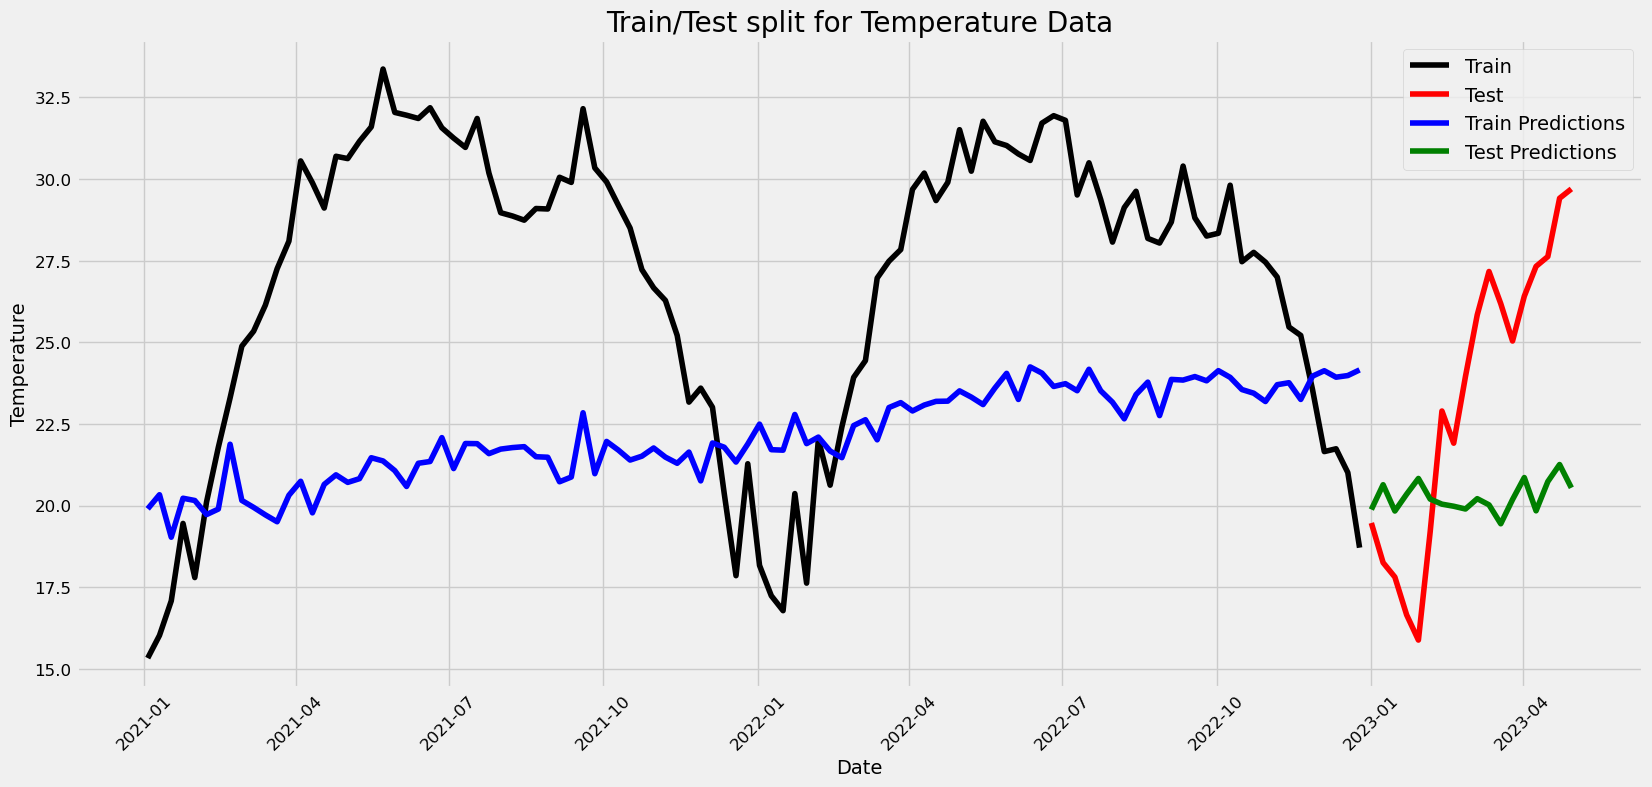

RMSE:  5.342144333207061


In [38]:
df2 = df2.set_index('datetime')

weeklydata = df2[['temp', 'humidity', 'windspeed']].resample('W').mean()
weeklydata.head()

train = weeklydata[weeklydata.index < pd.to_datetime("2023-01-01", format='%Y-%m-%d')]
test = weeklydata[weeklydata.index >= pd.to_datetime("2023-01-01", format='%Y-%m-%d')]

# Define exogenous variables for train and test
exog_columns_train = train.drop(['temp'], axis=1)  # Assuming temp as the target
exog_columns_test = test.drop(['temp'], axis=1)

# Display exogenous training features
exog_columns_train.head()

# SARIMAX model fitting
SARIMAXmodel = SARIMAX(train['temp'], exog=exog_columns_train, order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))
SARIMAXmodel = SARIMAXmodel.fit()

# Train set prediction
y_pred_train = SARIMAXmodel.get_forecast(len(train.index), exog=exog_columns_train)
y_pred_df_train = y_pred_train.conf_int(alpha=0.05)
y_pred_df_train["Predictions"] = SARIMAXmodel.predict(start=y_pred_df_train.index[0], end=y_pred_df_train.index[-1], exog=exog_columns_train)

# Aligning predictions with train index for plotting
y_pred_df_train.index = train.index
y_pred_out_train = y_pred_df_train["Predictions"]

# Test set prediction
y_pred = SARIMAXmodel.get_forecast(len(test.index), exog=exog_columns_test)
y_pred_df = y_pred.conf_int(alpha=0.05)
y_pred_df["Predictions"] = SARIMAXmodel.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1], exog=exog_columns_test)

# Aligning predictions with test index for plotting
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

# Plot the results
plt.plot(train['temp'], color="black", label='Train')
plt.plot(test['temp'], color="red", label='Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Temperature Data")

plt.plot(y_pred_out_train, color='blue', label='Train Predictions')
plt.plot(y_pred_out, color='green', label='Test Predictions')
plt.legend()
plt.show()

# Calculate RMSE
sarima_rmse = np.sqrt(mean_squared_error(test['temp'], y_pred_df["Predictions"]))
print("RMSE: ", sarima_rmse)

##### The RMSE is significantly higher when exogenous variables are included in the model (5.34 compared to 2.46). This indicates that the model’s predictions become less accurate when these external factors are added.